In [2]:
import pandas as pd
from pandas import Series,DataFrame

import numpy as np
import operator

import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid', context='notebook')

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

from sklearn import metrics
from sklearn.cross_validation import train_test_split, StratifiedKFold, cross_val_score

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
# Load data
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [5]:
# drop unnecessary columns, these columns won't be useful in analysis and prediction
train_df.drop(['Id'], axis=1, inplace=True)
test_df.drop(['Id'], axis=1, inplace=True)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59381 entries, 0 to 59380
Columns: 127 entries, Product_Info_1 to Response
dtypes: float64(18), int64(108), object(1)
memory usage: 58.0+ MB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19765 entries, 0 to 19764
Columns: 126 entries, Product_Info_1 to Medical_Keyword_48
dtypes: float64(18), int64(107), object(1)
memory usage: 19.2+ MB


In [8]:
train_df.head(3)

,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,1,D3,10,0.076923,2,1,1,0.641791,0.581818,0.148536,...,0,0,0,0,0,0,0,0,0,8
1,1,A1,26,0.076923,2,3,1,0.059701,0.600000,0.131799,...,0,0,0,0,0,0,0,0,0,4
2,1,E1,26,0.076923,2,3,1,0.029851,0.745455,0.288703,...,0,0,0,0,0,0,0,0,0,8


In [9]:
# Find columns which have null values, Usually it can be done by train_df.isnull().sum()
for col in train_df.columns:
    if train_df[col].isnull().sum() != 0:
        print(col, train_df[col].isnull().sum())
        #print(train_df[col].value_counts())

Employment_Info_1 19
Employment_Info_4 6779
Employment_Info_6 10854
Insurance_History_5 25396
Family_Hist_2 28656
Family_Hist_3 34241
Family_Hist_4 19184
Family_Hist_5 41811
Medical_History_1 8889
Medical_History_10 58824
Medical_History_15 44596
Medical_History_24 55580
Medical_History_32 58274


In [10]:
test_df.shape

(19765, 126)

In [11]:
# Find columns which have null values, Usually it can be done by test_df.isnull().sum()
for col in test_df.columns:
    if test_df[col].isnull().sum() != 0:
        print(col, test_df[col].isnull().sum())
        #print(test_df[col].value_counts())

Employment_Info_1 3
Employment_Info_4 2137
Employment_Info_6 3787
Insurance_History_5 8105
Family_Hist_2 9880
Family_Hist_3 11064
Family_Hist_4 6677
Family_Hist_5 13624
Medical_History_1 2972
Medical_History_10 19564
Medical_History_15 14864
Medical_History_24 18585
Medical_History_32 19414


In [12]:
# fill NaN values. We don't need to do this, xgboost does it automatically
#train_df.fillna(-1, inplace=True)
#test_df.fillna(-1, inplace=True)

In [13]:
#train_df[pd.isnull(train_df['PersonalField7'])].head(3)

In [14]:
# scatter plot matrix
#sns.pairplot(yelp, kind='reg')

# limit scatter plot matrix and add regression lines
#sns.pairplot(yelp, x_vars=['cool', 'useful', 'funny'], y_vars='stars', size=6, aspect=0.7, kind='reg')

In [15]:
# How many customers purchased insurance plan
#sns.countplot(x="QuoteConversion_Flag", data=train_df)

In [16]:
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# how many customers bought or did not buy policy
#sns.countplot(x='QuoteConversion_Flag', data=train_df, hue='Year', ax=ax1)

# which year has highest number of policies bought
#sns.countplot(x=train_df['Year'].loc[train_df['QuoteConversion_Flag'] == 1], order=[2013,2014,2015], ax=ax2)

In [17]:
# which month has highest number of policies bought
#sns.countplot(x=train_df['Month'].loc[train_df['QuoteConversion_Flag'] == 1], order=[1,2,3,4,5,6,7,8,9,10,11,12])

In [18]:
# There are some columns with non-numerical values(i.e. dtype='object'),
# So, We will create a corresponding unique numerical value for each non-numerical value in a column of training and testing set.

from sklearn import preprocessing

for f in train_df.columns:
    if train_df[f].dtype=='object':
        #print(f)
        lbl_encoder = preprocessing.LabelEncoder()
        lbl_encoder.fit(np.unique(list(train_df[f].values) + list(test_df[f].values)))
        train_df[f] = lbl_encoder.transform(list(train_df[f].values))
        test_df[f] = lbl_encoder.transform(list(test_df[f].values))

In [19]:
# define training and testing sets

lbl_encoder = preprocessing.LabelEncoder()
lbl_encoder.fit(np.unique(list(train_df['Response'].values)))
train_df['Response'] = lbl_encoder.transform(list(train_df['Response'].values))

y_train = train_df['Response']
X_train = train_df.drop('Response', axis=1)
X_test  = test_df.copy()
X_test = X_test[X_train.columns.tolist()] # maintain same column order between train and test data

In [20]:
print(X_train.columns)
print(X_test.columns)

Index(['Product_Info_1', 'Product_Info_2', 'Product_Info_3', 'Product_Info_4',
       'Product_Info_5', 'Product_Info_6', 'Product_Info_7', 'Ins_Age', 'Ht',
       'Wt',
       ...
       'Medical_Keyword_39', 'Medical_Keyword_40', 'Medical_Keyword_41',
       'Medical_Keyword_42', 'Medical_Keyword_43', 'Medical_Keyword_44',
       'Medical_Keyword_45', 'Medical_Keyword_46', 'Medical_Keyword_47',
       'Medical_Keyword_48'],
      dtype='object', length=126)
Index(['Product_Info_1', 'Product_Info_2', 'Product_Info_3', 'Product_Info_4',
       'Product_Info_5', 'Product_Info_6', 'Product_Info_7', 'Ins_Age', 'Ht',
       'Wt',
       ...
       'Medical_Keyword_39', 'Medical_Keyword_40', 'Medical_Keyword_41',
       'Medical_Keyword_42', 'Medical_Keyword_43', 'Medical_Keyword_44',
       'Medical_Keyword_45', 'Medical_Keyword_46', 'Medical_Keyword_47',
       'Medical_Keyword_48'],
      dtype='object', length=126)


In [21]:
def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()

In [22]:
features = list(X_train.columns)
ceate_feature_map(features)

In [23]:
# Calculate Feature Importance of the attributes
xgb_params = {"n_estimators":25, "objective": "multi:softmax", "num_class":8, "eta": 0.025, "max_depth": 10, "silent": 1, "eval_metric": "auc"}
num_rounds = 10

dtrain = xgb.DMatrix(X_train, label=y_train, missing=np.nan)
gbdt = xgb.train(xgb_params, dtrain, num_rounds)

importance = gbdt.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

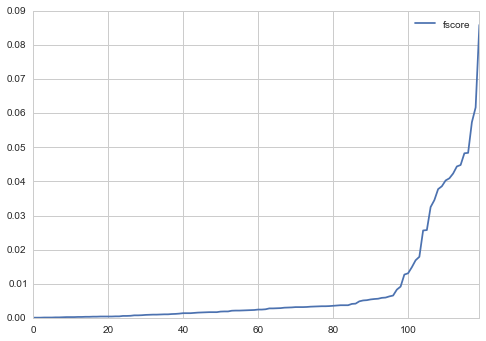

In [24]:
plt.figure()
df.plot()

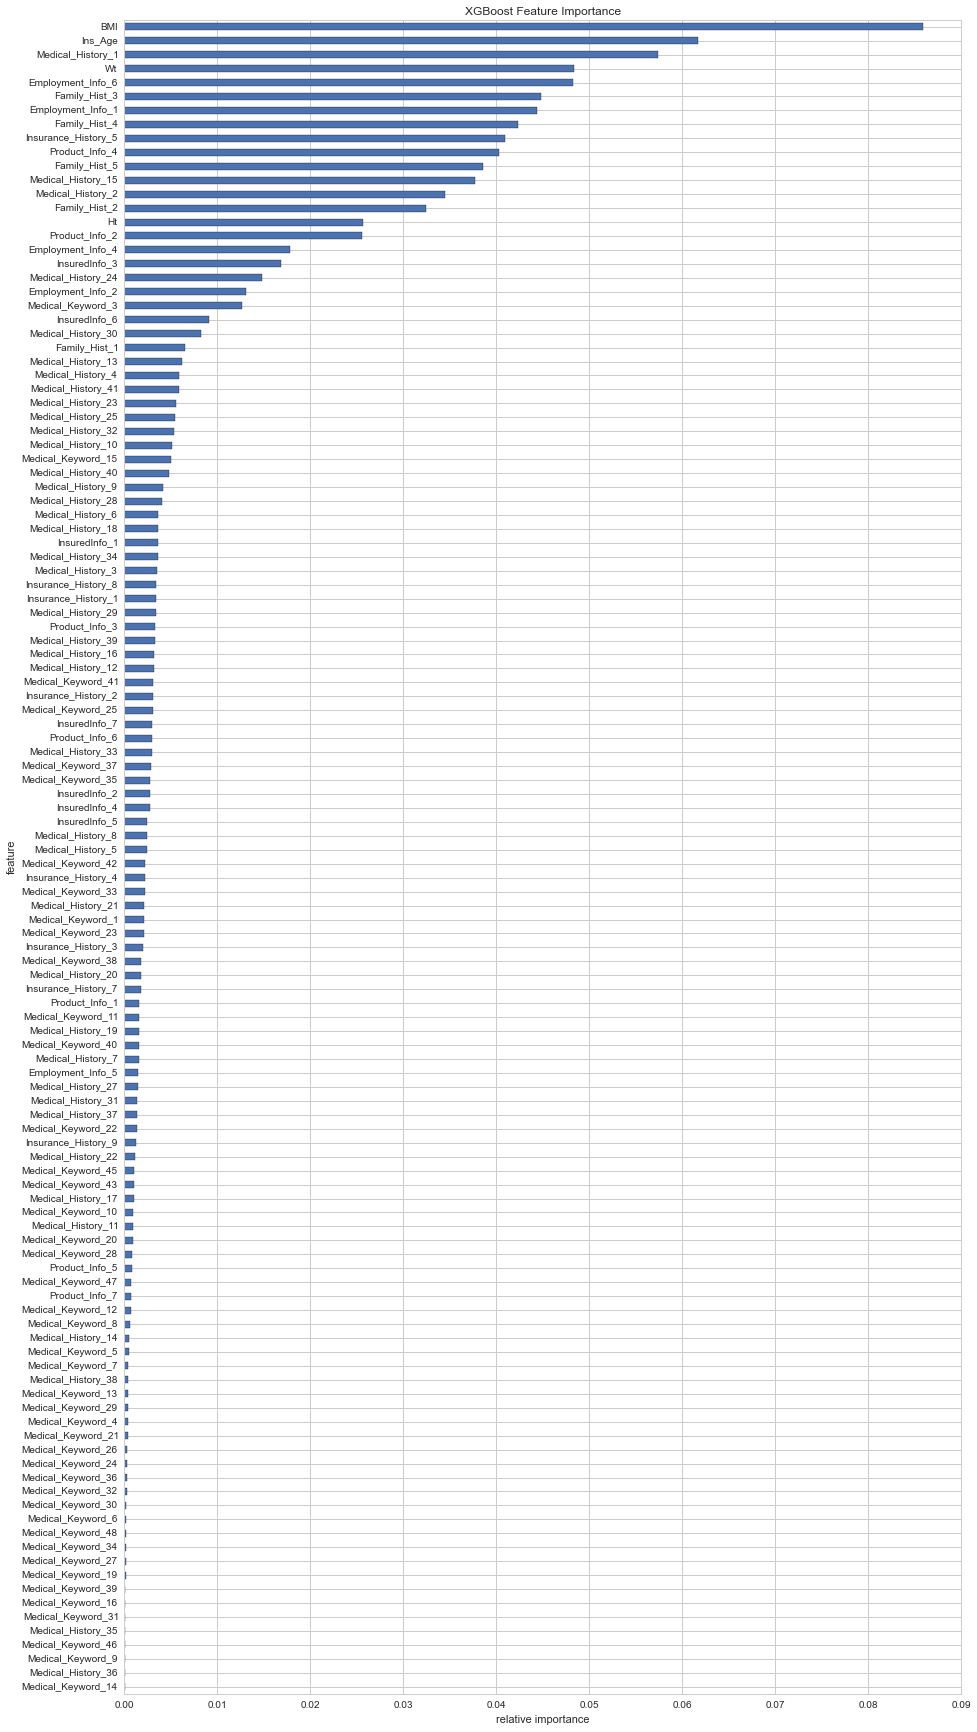

In [25]:
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(15, 30))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
#plt.gcf().savefig('feature_importance_xgb.png')

In [26]:
df.shape

(120, 2)

In [27]:
df[-35:]

,feature,fscore
85,Medical_History_28,0.004070
86,Medical_History_9,0.004155
87,Medical_History_40,0.004833
88,Medical_Keyword_15,0.005087
89,Medical_History_10,0.005172
90,Medical_History_32,0.005384
91,Medical_History_25,0.005511
92,Medical_History_23,0.005596
93,Medical_History_41,0.005850
94,Medical_History_4,0.005935


In [28]:
cdf = train_df[['Response'] + df[-35:]['feature'].tolist()]
cdf.corr()

,Response,Medical_History_28,Medical_History_9,Medical_History_40,Medical_Keyword_15,Medical_History_10,Medical_History_32,Medical_History_25,Medical_History_23,Medical_History_41,...,Product_Info_4,Insurance_History_5,Family_Hist_4,Employment_Info_1,Family_Hist_3,Employment_Info_6,Wt,Medical_History_1,Ins_Age,BMI
Response,1.000000,-0.092884,0.067236,0.131519,-0.259169,0.029199,0.144536,-0.000585,0.286584,-0.039022,...,0.202434,0.020420,-0.089378,0.040852,-0.003828,0.017766,-0.351395,0.103050,-0.209610,-0.381601
Medical_History_28,-0.092884,1.000000,-0.057597,-0.024677,0.045842,0.045349,-0.008368,0.012728,-0.048490,0.056271,...,-0.036345,-0.018091,-0.006731,-0.055175,-0.003716,-0.059717,0.014351,-0.041928,0.010299,0.047120
Medical_History_9,0.067236,-0.057597,1.000000,0.018757,-0.111138,-0.070946,-0.043221,0.021410,0.130126,-0.167193,...,0.042204,-0.004924,-0.138298,-0.032960,-0.044496,-0.093325,-0.029583,0.067721,-0.177294,-0.042192
Medical_History_40,0.131519,-0.024677,0.018757,1.000000,-0.013005,0.035025,-0.009113,0.009710,0.015563,-0.011265,...,0.021851,0.004705,-0.001264,-0.000808,0.008308,0.019352,-0.038010,0.006635,-0.003475,-0.011724
Medical_Keyword_15,-0.259169,0.045842,-0.111138,-0.013005,1.000000,0.143322,0.036408,-0.008662,-0.864042,0.098956,...,-0.158397,-0.028392,0.252884,-0.004206,0.050154,0.082476,0.219078,-0.148579,0.356782,0.255721
Medical_History_10,0.029199,0.045349,-0.070946,0.035025,0.143322,1.000000,0.508163,0.007745,-0.180504,0.174191,...,-0.183594,-0.008750,0.522520,0.020387,0.103877,0.305852,0.076757,-0.030902,0.542245,0.087712
Medical_History_32,0.144536,-0.008368,-0.043221,-0.009113,0.036408,0.508163,1.000000,0.019350,-0.029491,0.049706,...,-0.037740,-0.015571,0.088926,0.012383,-0.012734,0.066411,0.020762,-0.002235,0.105800,0.006272
Medical_History_25,-0.000585,0.012728,0.021410,0.009710,-0.008662,0.007745,0.019350,1.000000,0.009328,-0.055877,...,-0.027317,-0.009508,-0.007788,-0.040055,-0.005974,-0.033071,-0.040602,-0.033413,-0.003978,-0.005700
Medical_History_23,0.286584,-0.048490,0.130126,0.015563,-0.864042,-0.180504,-0.029491,0.009328,1.000000,-0.115265,...,0.163171,0.028401,-0.277010,-0.007493,-0.055433,-0.106536,-0.222439,0.157972,-0.391779,-0.253341
Medical_History_41,-0.039022,0.056271,-0.167193,-0.011265,0.098956,0.174191,0.049706,-0.055877,-0.115265,1.000000,...,-0.038086,-0.002599,0.100032,0.017690,0.045665,0.095902,-0.021374,-0.104091,0.155696,0.013723


D:\Work\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


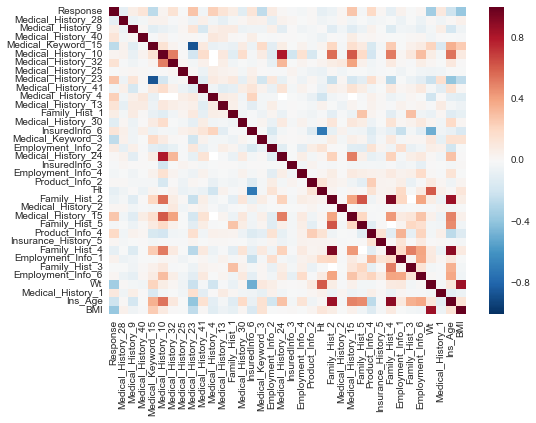

In [124]:
sns.heatmap(cdf.corr())

In [127]:
print(['Response'] + df[-35:]['feature'].tolist())

['Response', 'Medical_History_28', 'Medical_History_9', 'Medical_History_40', 'Medical_Keyword_15', 'Medical_History_10', 'Medical_History_32', 'Medical_History_25', 'Medical_History_23', 'Medical_History_41', 'Medical_History_4', 'Medical_History_13', 'Family_Hist_1', 'Medical_History_30', 'InsuredInfo_6', 'Medical_Keyword_3', 'Employment_Info_2', 'Medical_History_24', 'InsuredInfo_3', 'Employment_Info_4', 'Product_Info_2', 'Ht', 'Family_Hist_2', 'Medical_History_2', 'Medical_History_15', 'Family_Hist_5', 'Product_Info_4', 'Insurance_History_5', 'Family_Hist_4', 'Employment_Info_1', 'Family_Hist_3', 'Employment_Info_6', 'Wt', 'Medical_History_1', 'Ins_Age', 'BMI']


D:\Work\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


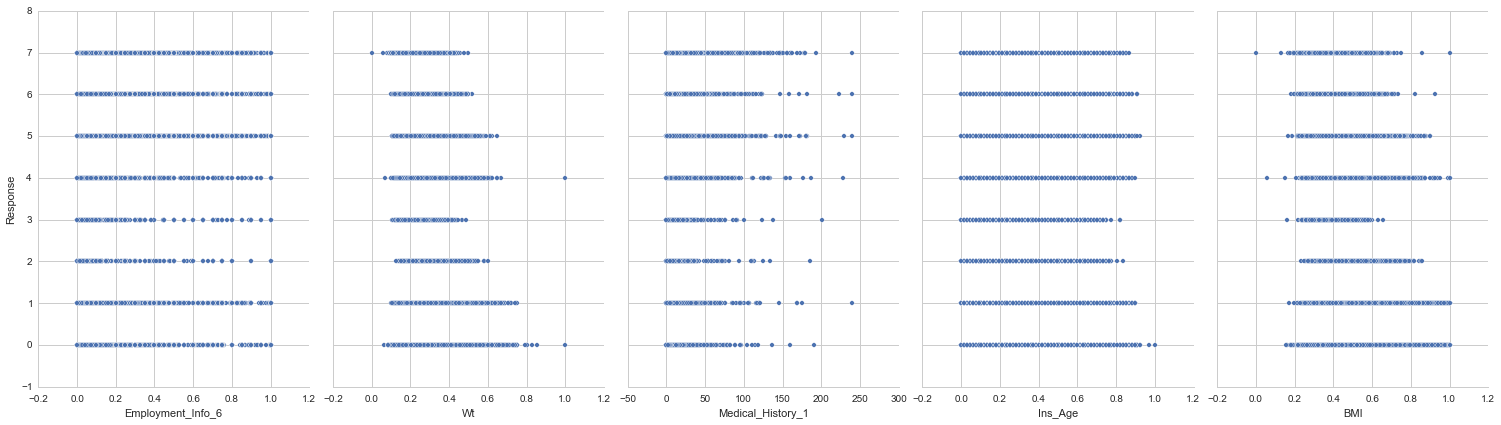

In [129]:
sns.pairplot(cdf, x_vars=['Employment_Info_6', 'Wt', 'Medical_History_1', 'Ins_Age', 'BMI'],
                                                     y_vars='Response', size=6, aspect=0.7)

In [108]:
# Low Importance Features
low_importance_features = []
low_importance_features.append(df[0:24]['feature'].tolist())
low_importance_features.append(df[0:41]['feature'].tolist())
low_importance_features.append(df[0:61]['feature'].tolist())
#low_importance_features

In [118]:
skf = StratifiedKFold(y_train, n_folds=5)
for low_importance_feature_set in low_importance_features:
    # Drop unwanted Features
    X_train_reduced = X_train.drop(low_importance_feature_set, axis=1)
    X_test_reduced = X_test.drop(low_importance_feature_set, axis=1)
    
    # 5 Fold Cross Validation with reduced features
    xgb_clf = xgb.XGBClassifier(n_estimators=25,
                            objective="multi:softmax",
                            nthread=3,
                            max_depth=10,
                            learning_rate=0.025,
                            silent=True,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            missing=np.nan)


    scores = []    
    for train_index, test_index in skf:
        xgb_clf.fit(X_train_reduced.iloc[train_index], y_train.iloc[train_index], eval_metric="auc")
        y_pred = xgb_clf.predict(X_train_reduced.iloc[test_index])
        scores.append(metrics.accuracy_score(y_train.iloc[test_index], y_pred))

    train_acc = np.array(scores).mean() * 100
    print('XGBoostClassifier Cross Validation Accuracy With %s Reduced Features: %.2f%%' % (len(low_importance_feature_set), train_acc))

XGBoostClassifier Cross Validation Accuracy With 24 Reduced Features: 58.56%
XGBoostClassifier Cross Validation Accuracy With 41 Reduced Features: 58.48%
XGBoostClassifier Cross Validation Accuracy With 61 Reduced Features: 58.42%


In [117]:
skf = StratifiedKFold(y_train, n_folds=5)

# Drop unwanted Features
X_train_reduced = X_train[df[-35:]['feature'].tolist()]
X_test_reduced = X_test[df[-35:]['feature'].tolist()]

# 5 Fold Cross Validation with reduced features
xgb_clf = xgb.XGBClassifier(n_estimators=25,
                        objective="multi:softmax",
                        nthread=2,
                        max_depth=10,
                        learning_rate=0.025,
                        silent=True,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        missing=np.nan)


scores = []    
for train_index, test_index in skf:
    xgb_clf.fit(X_train_reduced.iloc[train_index], y_train.iloc[train_index], eval_metric="auc")
    y_pred = xgb_clf.predict(X_train_reduced.iloc[test_index])
    scores.append(metrics.accuracy_score(y_train.iloc[test_index], y_pred))

train_acc = np.array(scores).mean() * 100
print('XGBoostClassifier Cross Validation Accuracy With %s Reduced Features: %.2f%%' % (len(low_importance_feature_set), train_acc))

XGBoostClassifier Cross Validation Accuracy With 61 Reduced Features: 58.06%


In [ ]:
# GridSearchCV with XGBoost 
xgb_clf = xgb.XGBClassifier(objective="binary:logistic",
                            nthread=-1,
                            learning_rate=0.025,
                            silent=True,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            missing=np.nan)

In [ ]:
from sklearn.grid_search import GridSearchCV
X_train_reduced = X_train.drop(low_importance_feature_set[0], axis=1)
param_grid = {'max_depth': [6,8,],
              'n_estimators': [200,500]}

gs = GridSearchCV(xgb_clf,
                  param_grid,
                  scoring='roc_auc',
                  cv=5,
                  n_jobs=1,
                  verbose=1)

gs.fit(X_train_reduced, y_train)
gs.best_score_, gs.best_params_
print(gs.best_estimator_)

In [ ]:
#clf = gs.best_estimator_
#clf.fit(X_train, y_train)
#y_pred_proba = clf.predict_proba(X_test)[:,1]

In [ ]:
# Create submission
#sample = pd.read_csv('data/sample_submission.csv')
#sample.QuoteConversion_Flag = y_pred_proba
#sample.head(10)

In [ ]:
#sample.to_csv('xgb_benchmark.csv', index=False)